# <font color='blue'>Data Science Academy</font>
# <font color='blue'>Deep Learning Frameworks</font>

## Mini-Projeto 4

## Detecção de Detalhes nas Faces em Fotos com Redes Neurais Convolucionais

In [1]:
# Versão da Linguagem Python
from platform import python_version
print('Versão da Linguagem Python Usada Neste Jupyter Notebook:', python_version())

Versão da Linguagem Python Usada Neste Jupyter Notebook: 3.7.6


Neste mini-projeto, vamos construir um modelo de Deep Learning, usando Convolutional Neural Network no Keras. Esse modelo será treinado usando o dataset de fotos de pessoas fornecido gratuitamente pelo Kaggle, em uma das suas competições no começo de 2017.

O dataset é composto de imagens de faces humanas, com tamanho 96 × 96 em escala de cinza, juntamente com 15 marcos faciais correspondentes, relatados nas coordenadas (x, y). Visualizando alguns dos dados abaixo, e você pode ver que há dois pontos de referência por sobrancelha (quatro total), três por olho (seis total), quatro para a boca e outro para a ponta do nariz.

O objetivo é criar um algoritmo que possa aprender com os padrões desses dados, a fim de prever os marcos faciais nas novas imagens.

Treinaremos uma rede neural convolucional (CNN) composta de pilhas de camadas. A CNN recebe uma imagem como entrada, e sua camada final exibe um vetor com 30 entradas, correspondendo às posições previstas do modelo de cada um dos 15 pontos-chave do rosto. A CNN contém mais de 7 milhões de pesos adequados aos dados de treinamento.

Competição Kaggle: https://www.kaggle.com/c/facial-keypoints-detection

Dataset: https://www.kaggle.com/c/facial-keypoints-detection/data

In [2]:
!nvidia-smi

Fri May 29 21:47:31 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 440.64.00    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN X (Pascal)    On   | 00000000:05:00.0 Off |                  N/A |
| 23%   38C    P8     9W / 250W |    114MiB / 12194MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  On   | 00000000:09:00.0 Off |                  N/A |
| 23%   34C    P8     9W / 250W |      2MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [3]:
# Para atualizar um pacote, execute o comando abaixo no terminal ou prompt de comando:
# pip install -U nome_pacote

# Para instalar a versão exata de um pacote, execute o comando abaixo no terminal ou prompt de comando:
# pip install nome_pacote==versão_desejada

# Depois de instalar ou atualizar o pacote, reinicie o jupyter notebook.

# Instala o pacote watermark. 
# Esse pacote é usado para gravar as versões de outros pacotes usados neste jupyter notebook.
!pip install -q -U watermark

In [4]:
# Import dos módulos
import os
import keras
import tensorflow
import matplotlib
import pandas
import numpy as np
import keras.backend as K
import matplotlib.pyplot as plt
from pandas.io.parsers import read_csv
from sklearn.utils import shuffle
from keras.layers import Convolution2D, MaxPooling2D, Dropout
from keras.layers import Flatten, Dense
from keras.optimizers import SGD
from keras.models import Sequential
%matplotlib inline

Using TensorFlow backend.


In [5]:
# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
%watermark -a "Data Science Academy" --iversions

tensorflow 2.2.0
keras      2.3.1
numpy      1.18.4
pandas     1.0.3
matplotlib 3.2.1
Data Science Academy


### IImport do Dataset

In [6]:
# Se os arquivos training e test estiverem no formato zip, descompacte-os.
FTRAIN = 'training.csv'
FTEST = 'test.csv'

def load(test = False):
    """
    Carrega dados de FTEST se * test * for True, caso contrário, FTRAIN.
    """  
    fname = FTEST if test else FTRAIN
    df = read_csv(os.path.expanduser(fname))  

    # A coluna Imagem tem valores de pixel separados por espaço.
    # Convertemos oa valores para arrays NumPy:
    df['Image'] = df['Image'].apply(lambda im: np.fromstring(im, sep=' '))

    # Drop de todas as linhas que tenham valores faltantes
    df = df.dropna()  

     # Scale pixel com valores [0, 1]
    X = np.vstack(df['Image'].values) / 255. 
    X = X.astype(np.float32)
    X = X.reshape(-1, 96, 96, 1)

    # Somente FTRAIN tem coluna de destino (target)
    if not test:  
        y = df[df.columns[:-1]].values
         
        # Scale target coordinates para [-1, 1]
        y = (y - 48) / 48 
        
        # Shuffle train data
        X, y = shuffle(X, y, random_state = 42)  
        y = y.astype(np.float32)
    else:
        y = None

    return X, y

In [7]:
# Carregando Dados de Treino
X, y = load()
print("X.shape == {}".format(X.shape))
print("y.shape == {}; y.min == {:.3f}; y.max == {:.3f}".format(y.shape, y.min(), y.max()))

X.shape == (2140, 96, 96, 1)
y.shape == (2140, 30); y.min == -0.920; y.max == 0.996


In [8]:
# Carregando dados de teste
X_test, _ = load(test=True)
print("X_test.shape == {}".format(X_test.shape))

X_test.shape == (1783, 96, 96, 1)


### Visualizando um Subset do Dataset de Treino

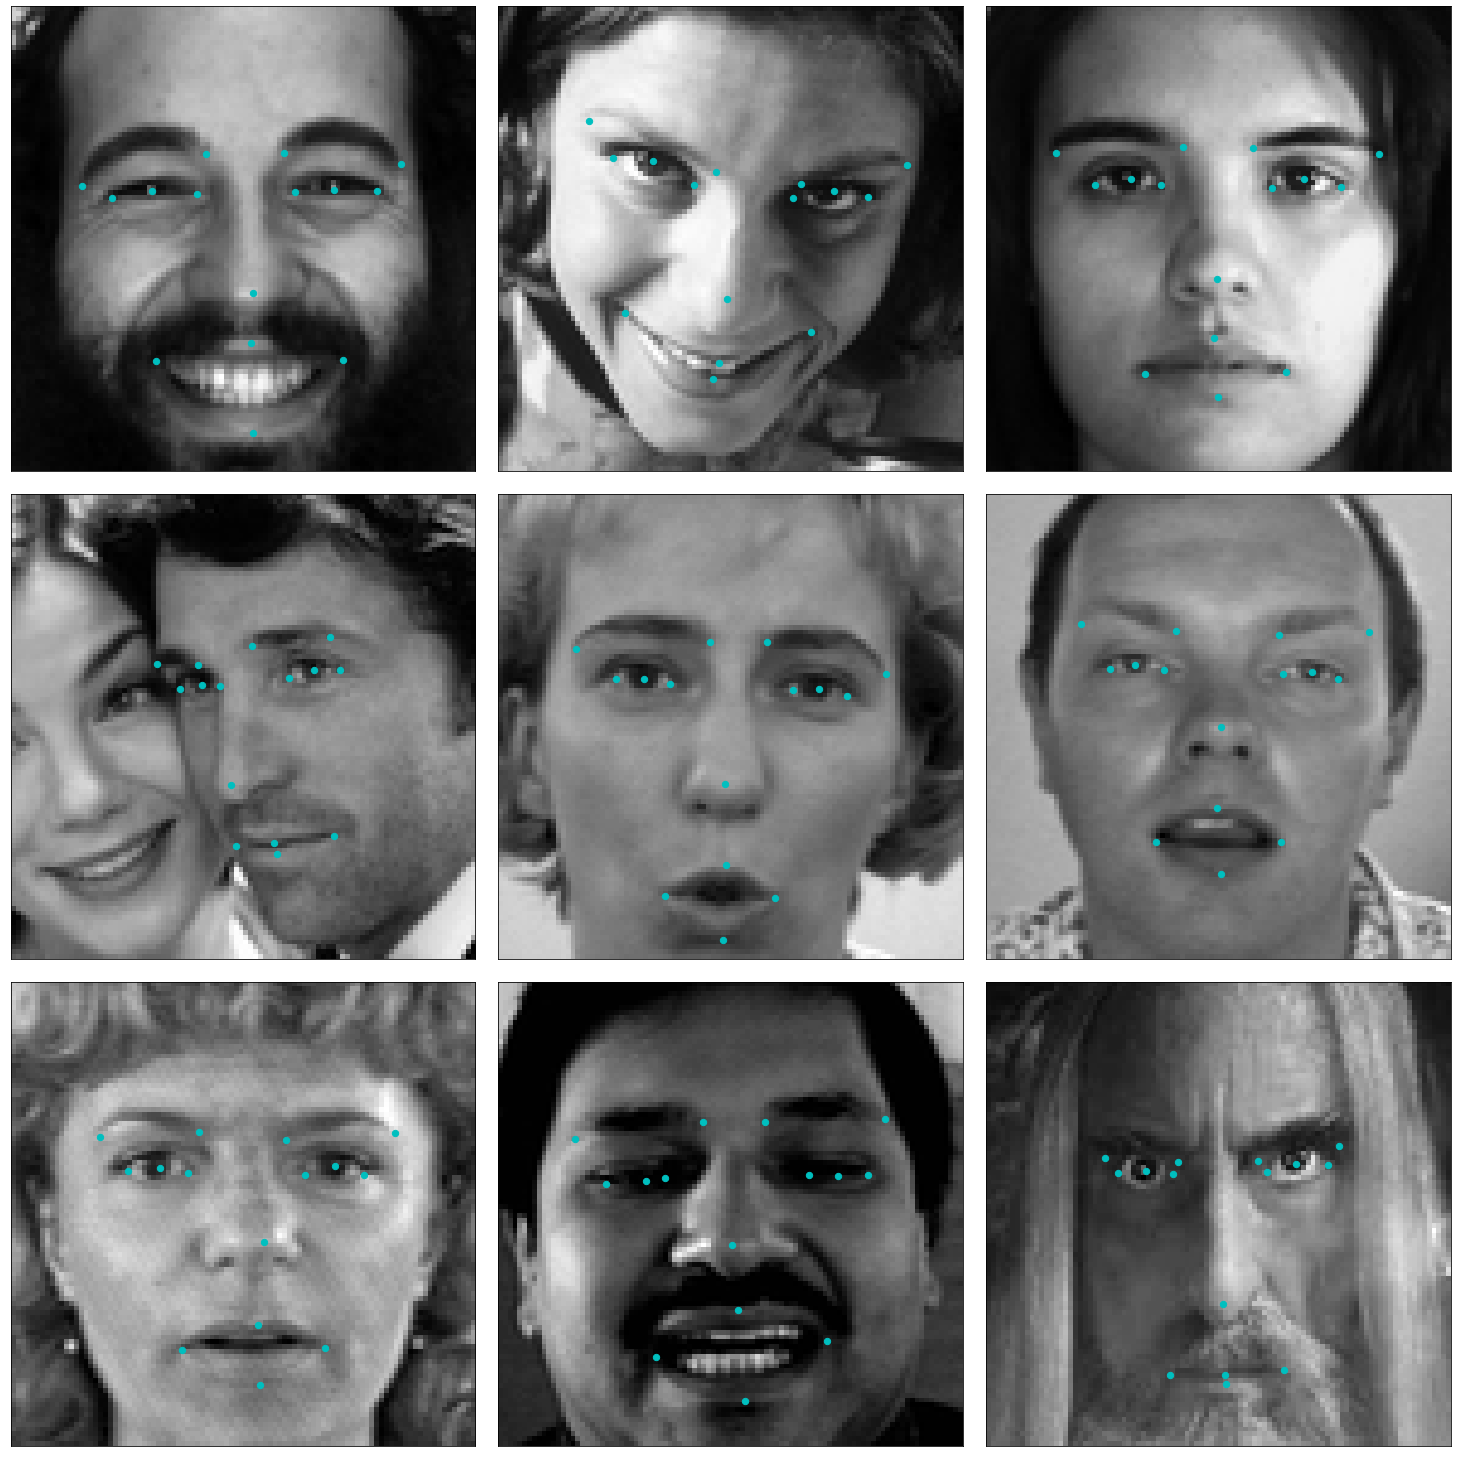

In [9]:
def plot_data(img, landmarks, axis):
    axis.imshow(np.squeeze(img), cmap='gray')
    axis.scatter(landmarks[0::2] * 48 + 48, landmarks[1::2] * 48 + 48, marker='o', c='c', s=40)
    
fig = plt.figure(figsize=(20,20))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
for i in range(9):
    ax = fig.add_subplot(3, 3, i + 1, xticks=[], yticks=[])
    plot_data(X[i], y[i], ax)

### Arquitetura do Modelo

A adequação de qualquer coleção de modelos de pesos do modelo é avaliada de acordo com a função de perda de erro quadrático médio (MSE). O MSE é minimizado quando os pesos produzem um modelo com previsões que se alinham bem com os valores reais dos pontos-chave do rosto. Durante o processo de treinamento, a rede procura pesos que minimizam o MSE.

Existem muitos otimizadores diferentes em Keras que podem ser usados para encontrar os pesos e minimizar o MSE. Usamos aqui o Stochastic Gradient Descent. Uma vez que os pesos são obtidos, eles são usados para prever a localização dos marcos faciais em novas imagens! 

In [10]:
model = Sequential()

# conv1
model.add(Convolution2D(32, (3, 3), activation = 'relu', input_shape = (96, 96, 1)))

# pool1
model.add(MaxPooling2D((2, 2)))

# conv2
model.add(Convolution2D(64, (2, 2), activation = 'relu'))

# pool2
model.add(MaxPooling2D((2, 2)))

# conv3
model.add(Convolution2D(128, (2, 2), activation = 'relu'))

# pool3
model.add(MaxPooling2D((2, 2)))

# flatten
model.add(Flatten())

# dense1
model.add(Dense(500, activation = 'relu'))

# dense2
model.add(Dense(30))

# print
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 94, 94, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 47, 47, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 46, 46, 64)        8256      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 22, 22, 128)       32896     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 11, 11, 128)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 15488)            

### Treinamento do Modelo

Como você aprendeu ao longo do curso, o ideal é começar seu desenvolvimento em Deep Learning, com a construção de um pipeline de ponta a ponta antes de realizar um extenso ajuste de hiperparâmetros. Os ajustes podem ser feitos à medida que queremos aumentar a acurácia. Lembre-se de realizar os ajustes um por vez. Evite alterar muitos parâmetros ao mesmo tempo!

In [11]:
sgd = SGD(lr = 0.01, momentum = 0.9, nesterov = True)
model.compile(optimizer = sgd, loss = 'mse')
hist = model.fit(X, y, epochs = 500, validation_split = 0.2)

Train on 1712 samples, validate on 428 samples
Epoch 1/500
1712/1712 [==============================] - 2s 1ms/step - loss: 0.0337 - val_loss: 0.0059
Epoch 2/500
1712/1712 [==============================] - 0s 231us/step - loss: 0.0058 - val_loss: 0.0053
Epoch 3/500
1712/1712 [==============================] - 0s 232us/step - loss: 0.0053 - val_loss: 0.0049
Epoch 4/500
1712/1712 [==============================] - 0s 234us/step - loss: 0.0050 - val_loss: 0.0048
Epoch 5/500
1712/1712 [==============================] - 0s 231us/step - loss: 0.0048 - val_loss: 0.0046
Epoch 6/500
1712/1712 [==============================] - 0s 230us/step - loss: 0.0047 - val_loss: 0.0046
Epoch 7/500
1712/1712 [==============================] - 0s 235us/step - loss: 0.0046 - val_loss: 0.0045
Epoch 8/500
1712/1712 [==============================] - 0s 235us/step - loss: 0.0045 - val_loss: 0.0045
Epoch 9/500
1712/1712 [==============================] - 0s 236us/step - loss: 0.0045 - val_loss: 0.0045
Epoch 10/5

Epoch 78/500
1712/1712 [==============================] - 0s 235us/step - loss: 0.0030 - val_loss: 0.0031
Epoch 79/500
1712/1712 [==============================] - 0s 237us/step - loss: 0.0030 - val_loss: 0.0030
Epoch 80/500
1712/1712 [==============================] - 0s 234us/step - loss: 0.0030 - val_loss: 0.0030
Epoch 81/500
1712/1712 [==============================] - 0s 235us/step - loss: 0.0029 - val_loss: 0.0030
Epoch 82/500
1712/1712 [==============================] - 0s 229us/step - loss: 0.0029 - val_loss: 0.0029
Epoch 83/500
1712/1712 [==============================] - 0s 237us/step - loss: 0.0029 - val_loss: 0.0029
Epoch 84/500
1712/1712 [==============================] - 0s 235us/step - loss: 0.0028 - val_loss: 0.0029
Epoch 85/500
1712/1712 [==============================] - 0s 236us/step - loss: 0.0028 - val_loss: 0.0029
Epoch 86/500
1712/1712 [==============================] - 0s 233us/step - loss: 0.0028 - val_loss: 0.0029
Epoch 87/500
1712/1712 [======================

Epoch 155/500
1712/1712 [==============================] - 0s 235us/step - loss: 0.0017 - val_loss: 0.0019
Epoch 156/500
1712/1712 [==============================] - 0s 233us/step - loss: 0.0017 - val_loss: 0.0019
Epoch 157/500
1712/1712 [==============================] - 0s 236us/step - loss: 0.0017 - val_loss: 0.0019
Epoch 158/500
1712/1712 [==============================] - 0s 235us/step - loss: 0.0017 - val_loss: 0.0019
Epoch 159/500
1712/1712 [==============================] - 0s 236us/step - loss: 0.0017 - val_loss: 0.0019
Epoch 160/500
1712/1712 [==============================] - 0s 233us/step - loss: 0.0017 - val_loss: 0.0019
Epoch 161/500
1712/1712 [==============================] - 0s 233us/step - loss: 0.0017 - val_loss: 0.0019
Epoch 162/500
1712/1712 [==============================] - 0s 232us/step - loss: 0.0016 - val_loss: 0.0019
Epoch 163/500
1712/1712 [==============================] - 0s 230us/step - loss: 0.0016 - val_loss: 0.0019
Epoch 164/500
1712/1712 [============

1712/1712 [==============================] - 0s 234us/step - loss: 0.0013 - val_loss: 0.0017
Epoch 232/500
1712/1712 [==============================] - 0s 234us/step - loss: 0.0013 - val_loss: 0.0017
Epoch 233/500
1712/1712 [==============================] - 0s 235us/step - loss: 0.0013 - val_loss: 0.0016
Epoch 234/500
1712/1712 [==============================] - 0s 237us/step - loss: 0.0013 - val_loss: 0.0016
Epoch 235/500
1712/1712 [==============================] - 0s 236us/step - loss: 0.0013 - val_loss: 0.0017
Epoch 236/500
1712/1712 [==============================] - 0s 237us/step - loss: 0.0013 - val_loss: 0.0016
Epoch 237/500
1712/1712 [==============================] - 0s 232us/step - loss: 0.0013 - val_loss: 0.0016
Epoch 238/500
1712/1712 [==============================] - 0s 230us/step - loss: 0.0013 - val_loss: 0.0016
Epoch 239/500
1712/1712 [==============================] - 0s 234us/step - loss: 0.0013 - val_loss: 0.0016
Epoch 240/500
1712/1712 [==========================

1712/1712 [==============================] - 0s 232us/step - loss: 0.0011 - val_loss: 0.0015
Epoch 308/500
1712/1712 [==============================] - 0s 231us/step - loss: 0.0011 - val_loss: 0.0015
Epoch 309/500
1712/1712 [==============================] - 0s 232us/step - loss: 0.0011 - val_loss: 0.0015
Epoch 310/500
1712/1712 [==============================] - 0s 233us/step - loss: 0.0011 - val_loss: 0.0015
Epoch 311/500
1712/1712 [==============================] - 0s 236us/step - loss: 0.0011 - val_loss: 0.0015
Epoch 312/500
1712/1712 [==============================] - 0s 234us/step - loss: 0.0011 - val_loss: 0.0015
Epoch 313/500
1712/1712 [==============================] - 0s 235us/step - loss: 0.0011 - val_loss: 0.0015
Epoch 314/500
1712/1712 [==============================] - 0s 236us/step - loss: 0.0011 - val_loss: 0.0015
Epoch 315/500
1712/1712 [==============================] - 0s 237us/step - loss: 0.0011 - val_loss: 0.0015
Epoch 316/500
1712/1712 [==========================

1712/1712 [==============================] - 0s 234us/step - loss: 9.8845e-04 - val_loss: 0.0015
Epoch 384/500
1712/1712 [==============================] - 0s 236us/step - loss: 9.8707e-04 - val_loss: 0.0015
Epoch 385/500
1712/1712 [==============================] - 0s 237us/step - loss: 9.8855e-04 - val_loss: 0.0015
Epoch 386/500
1712/1712 [==============================] - 0s 238us/step - loss: 9.8362e-04 - val_loss: 0.0014
Epoch 387/500
1712/1712 [==============================] - 0s 234us/step - loss: 9.8360e-04 - val_loss: 0.0014
Epoch 388/500
1712/1712 [==============================] - 0s 230us/step - loss: 9.8025e-04 - val_loss: 0.0014
Epoch 389/500
1712/1712 [==============================] - 0s 232us/step - loss: 9.7719e-04 - val_loss: 0.0014
Epoch 390/500
1712/1712 [==============================] - 0s 232us/step - loss: 9.7642e-04 - val_loss: 0.0014
Epoch 391/500
1712/1712 [==============================] - 0s 234us/step - loss: 9.7713e-04 - val_loss: 0.0014
Epoch 392/500
1

Epoch 457/500
1712/1712 [==============================] - 0s 235us/step - loss: 8.8183e-04 - val_loss: 0.0014
Epoch 458/500
1712/1712 [==============================] - 0s 235us/step - loss: 8.8208e-04 - val_loss: 0.0014
Epoch 459/500
1712/1712 [==============================] - 0s 234us/step - loss: 8.7909e-04 - val_loss: 0.0014
Epoch 460/500
1712/1712 [==============================] - 0s 232us/step - loss: 8.7806e-04 - val_loss: 0.0014
Epoch 461/500
1712/1712 [==============================] - 0s 234us/step - loss: 8.7596e-04 - val_loss: 0.0014
Epoch 462/500
1712/1712 [==============================] - 0s 232us/step - loss: 8.7287e-04 - val_loss: 0.0014
Epoch 463/500
1712/1712 [==============================] - 0s 227us/step - loss: 8.7307e-04 - val_loss: 0.0014
Epoch 464/500
1712/1712 [==============================] - 0s 231us/step - loss: 8.7250e-04 - val_loss: 0.0014
Epoch 465/500
1712/1712 [==============================] - 0s 233us/step - loss: 8.7030e-04 - val_loss: 0.0014
E

### Visualizando um Subset das Previsões

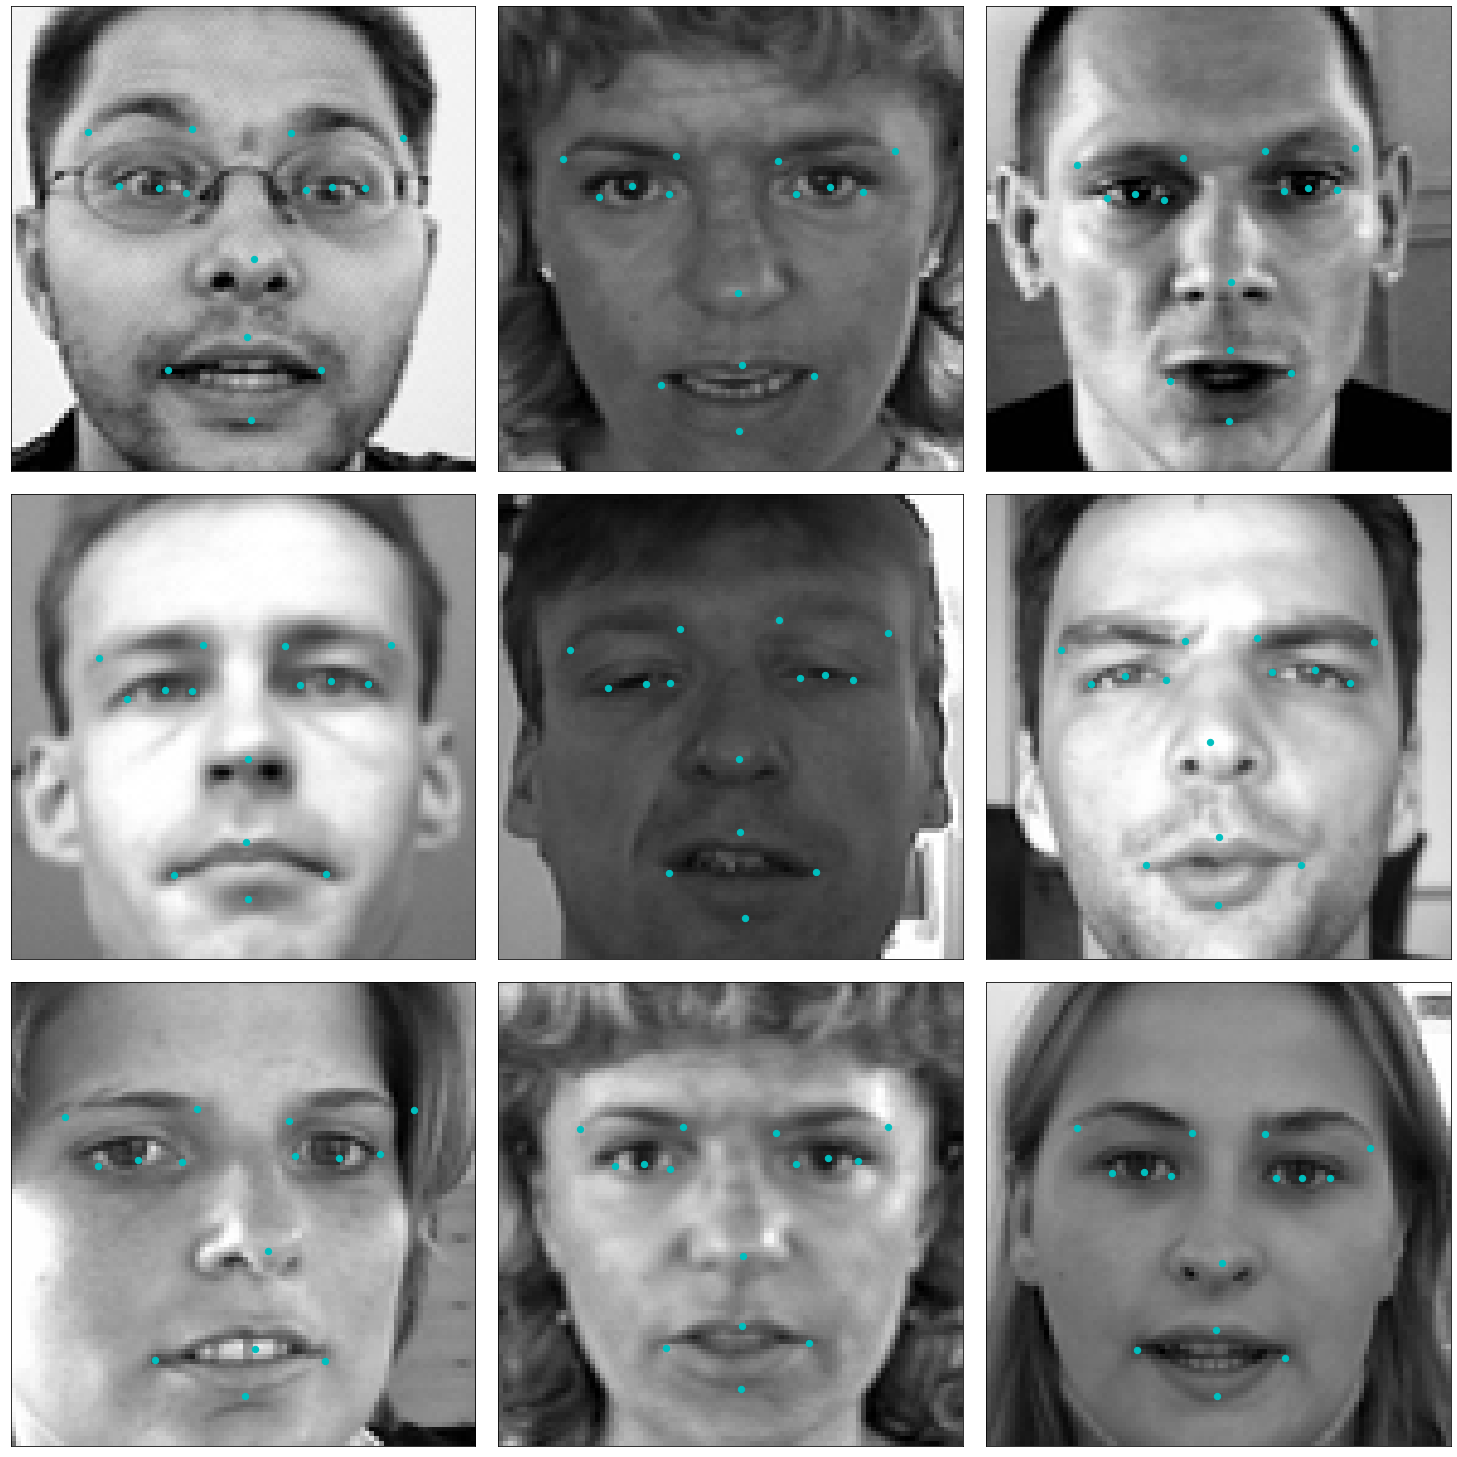

In [12]:
y_test = model.predict(X_test)
fig = plt.figure(figsize = (20,20))
fig.subplots_adjust(left = 0, right = 1, bottom = 0, top = 1, hspace = 0.05, wspace = 0.05)
for i in range(9):
    ax = fig.add_subplot(3, 3, i + 1, xticks=[], yticks=[])
    plot_data(X_test[i], y_test[i], ax)

## Fim